In [1]:
import stability_functions as sf
import numpy as np
from numpy.random import normal, seed, uniform
import os
import time
import sys
import rebound
import mr_forecast as mr
import numpy.random as rd
import corner
import copy
import scipy
import pandas as pd
from scipy import optimize
import random
import dill
import sys
sys.path.append("../spock")
from spock import StabilityClassifier
import dask.dataframe as dd
from celmech import Andoyer
from multiprocessing import Pool
# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
plt.style.use('paper.mplstyle')
cmaprb = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
# %matplotlib inline

# Generating systems and scores

In [2]:
sim_names = "K431/K431_uni_e"
use_log_e = False
n = 10000
n_workers = 4  # ?

In [3]:
def init_process():
    global model
    model = StabilityClassifier()
    
def pred(nsim):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]
    sim.move_to_com()
    sim.integrator="whfast"
    sim.dt = 0.07*sim.particles[1].P
#     prob=model.predict(sim)
    prob=model.predict(sim, copy=False)
    return prob

def get_k(row):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%(row[0]))[0]
#     print(sim)
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=4, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    row['e1'] = sim.particles[1].e
    row['e2'] = sim.particles[2].e
    row['e3'] = sim.particles[3].e
    row['m1'] = sim.particles[1].m
    row['m2'] = sim.particles[2].m
    row['m3'] = sim.particles[3].m
    return row

pool = Pool(processes=n_workers, initializer=init_process)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

In [4]:
%%time
mb, mc, md = sf.draw_massesK431(int(3e3))

CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 10.7 s


In [5]:
%%time
# log_min_e = np.ones(3) * np.log(1e-3)

for i in range(n):
    name = sim_names + "_sa_%d.bin"%i
    Ps = np.array([sf.a_normal(6.80252171, 7.931e-05, 7.931e-05), sf.a_normal(8.70337044, 9.645e-05, 9.645e-05), sf.a_normal(11.9216214, 0.0001182, 0.0001182)]) / sf.days_p_year
    As = Ps ** (2./3)
    es = np.array([0,0,0])
    bad_es = True
    e0_max = sf.max_e_inner(As[0], As[1])
    e1_max = np.minimum(sf.max_e_inner(As[1], As[2], es[2]), sf.max_e_outer(As[1], As[0]))  # ~0.15
    e2_max = sf.max_e_outer(As[2], As[1])
    while bad_es:
#         if use_log_e:
#             es = np.exp(rd.rand(3) * (np.log([e0_max, e1_max, e2_max]) - log_min_e) + log_min_e)
#         else:
        es = rd.rand(3) * np.array([e0_max, e1_max, e2_max])
        bad_es = not sf.check_es(As[0], es[0], As[1], es[1], As[2], es[2])
    bad_ms = True
    while bad_ms:
        sim = sf.build_K431(mb, mc, md, es, Ps)
        bad_ms = any([sim.particles[i].m < 0 for i in range(1,4)])
    sf.replace_snapshot(sim, name)

CPU times: user 21.2 s, sys: 5.1 s, total: 26.3 s
Wall time: 2min 56s


In [31]:
%%time
nsim_list = np.arange(0,n)
res = pool.map(pred, nsim_list)

CPU times: user 14 ms, sys: 5 ms, total: 19 ms
Wall time: 8.9 s


In [22]:
%%time
df1 = pd.DataFrame(nsim_list, columns=['sim'])
df1['k'] = 0.
df1['h'] = 0.
df1['Z12'] = 0.
df1['Zcom12'] = 0.
df1['Z23'] = 0.
df1['Zcom23'] = 0.
df1['e1'] = 0.
df1['e2'] = 0.
df1['e3'] = 0.
df1['m1'] = 0.
df1['m2'] = 0.
df1['m3'] = 0.
df1['probstability'] = res

dasklabels = dd.from_pandas(df1, npartitions=n_workers)
df = dasklabels.apply(get_k, axis=1, meta=df1).compute(scheduler='processes')

df.to_csv("K431_uni_e.csv")

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


CPU times: user 56 ms, sys: 62 ms, total: 118 ms
Wall time: 340 ms


# Corner plots

In [2]:
df = pd.read_csv("K431_uni_e.csv")
df["m1"] /= sf.earth_mass_2_solar_mass
df["m2"] /= sf.earth_mass_2_solar_mass
df["m3"] /= sf.earth_mass_2_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]
scores = 2 * df["probstability"]
n = len(scores)
# effective sample size using eq 9.13 https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf
effective_sample_size = n * np.mean(scores) ** 2 / np.mean(scores ** 2)
print(effective_sample_size)
print(n)
print(effective_sample_size / n)

1089.2345837203964
10000
0.10892345837203964


In [3]:
def quantile_1D(data, weights, quantile):
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    Sn =  np.array(np.cumsum(sorted_weights))
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    return np.interp(quantile, Pn, sorted_data)

In [4]:
def create_hist(label, show_quantiles=True):
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6, weights=df["probstability"])
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(label, size=30)
    if show_quantiles:
        quant1 = np.quantile(df[label], 0.16)
        quant2 = np.quantile(df[label], 0.84)
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        quant3 = quantile_1D(df[label], df["probstability"], 0.16)
        quant4 = quantile_1D(df[label], df["probstability"], 0.84)
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        sigma1 = (quant2 - quant1) / 2
        sigma2 = (quant4 - quant3) / 2
        print("\"sigma\" before: %f"%(sigma1))
        print("\"sigma\" after: %f"%(sigma2))
        print("factor of %f smaller"%(sigma1/sigma2))

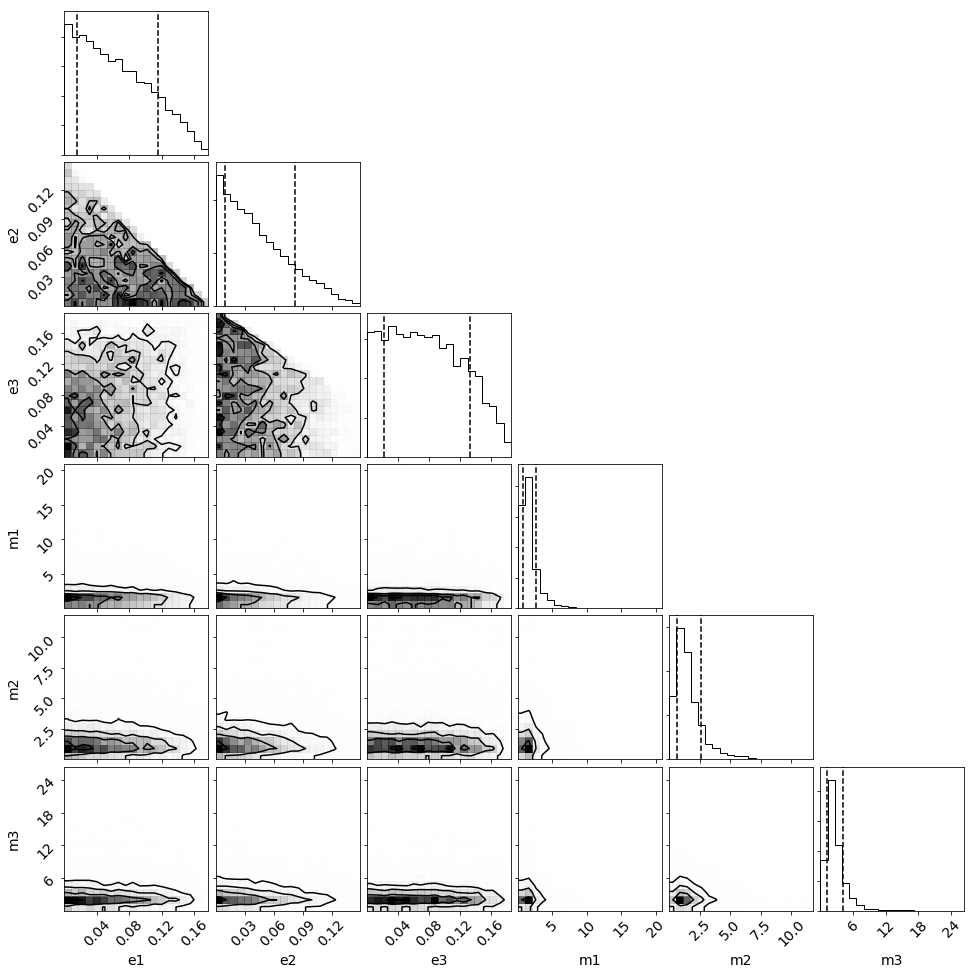

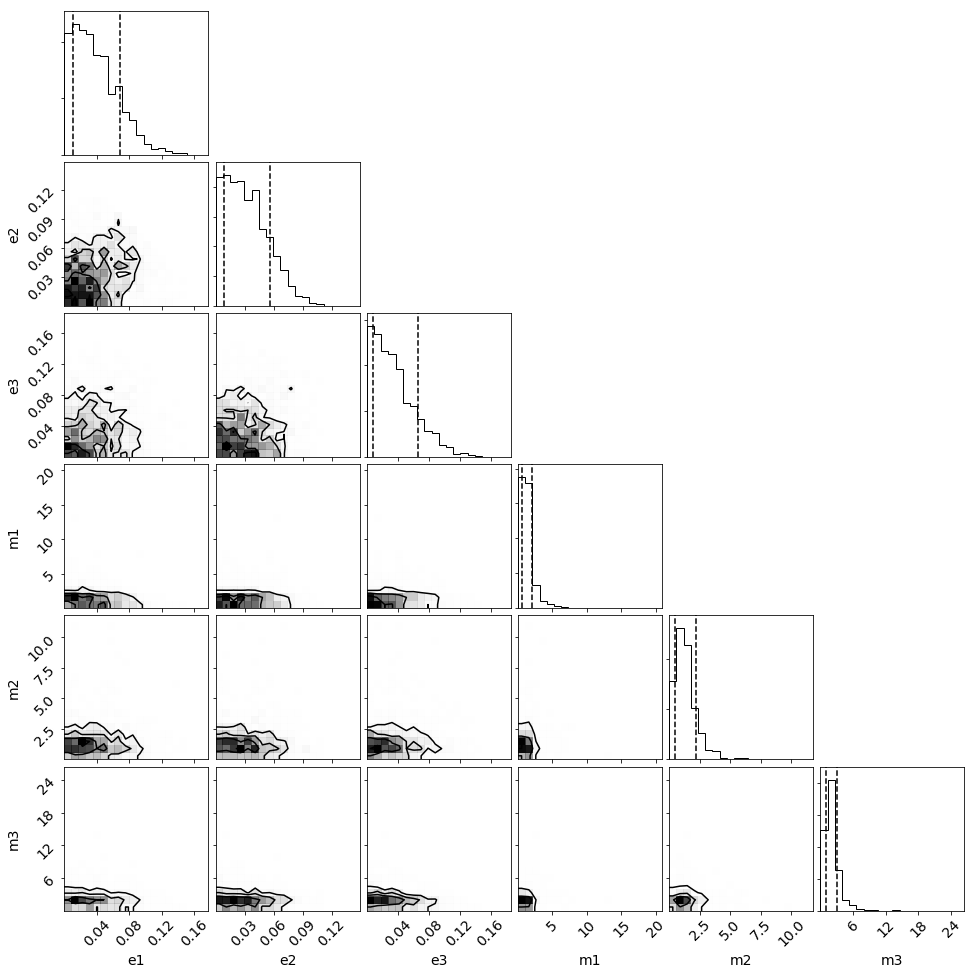

In [5]:
labels = ["e1","e2", "e3", "m1", "m2", "m3"]
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False)
plt.show()
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.show()

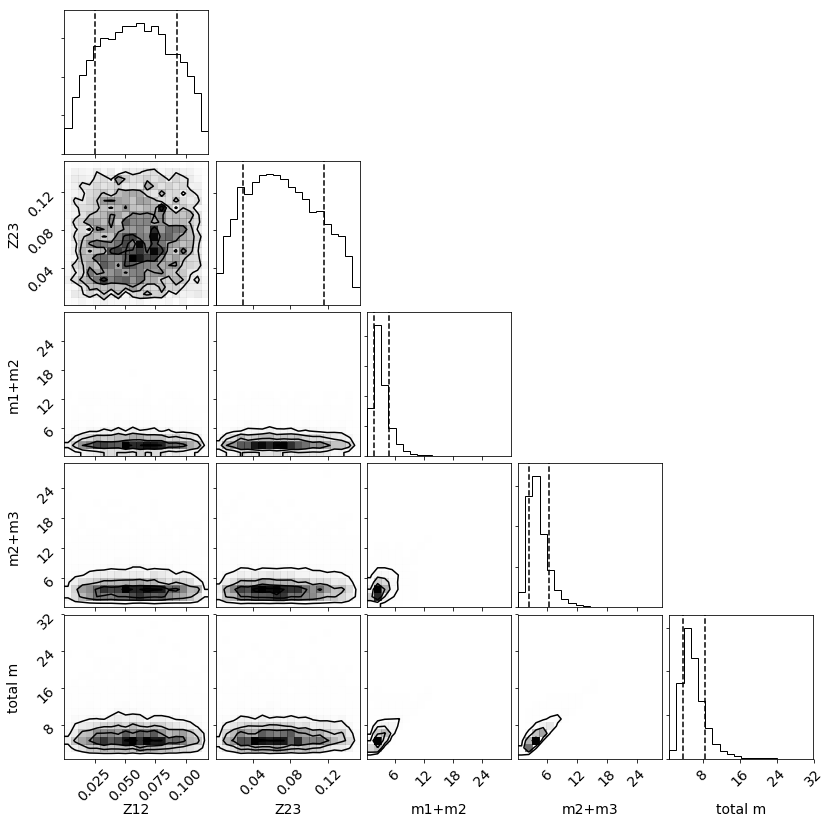

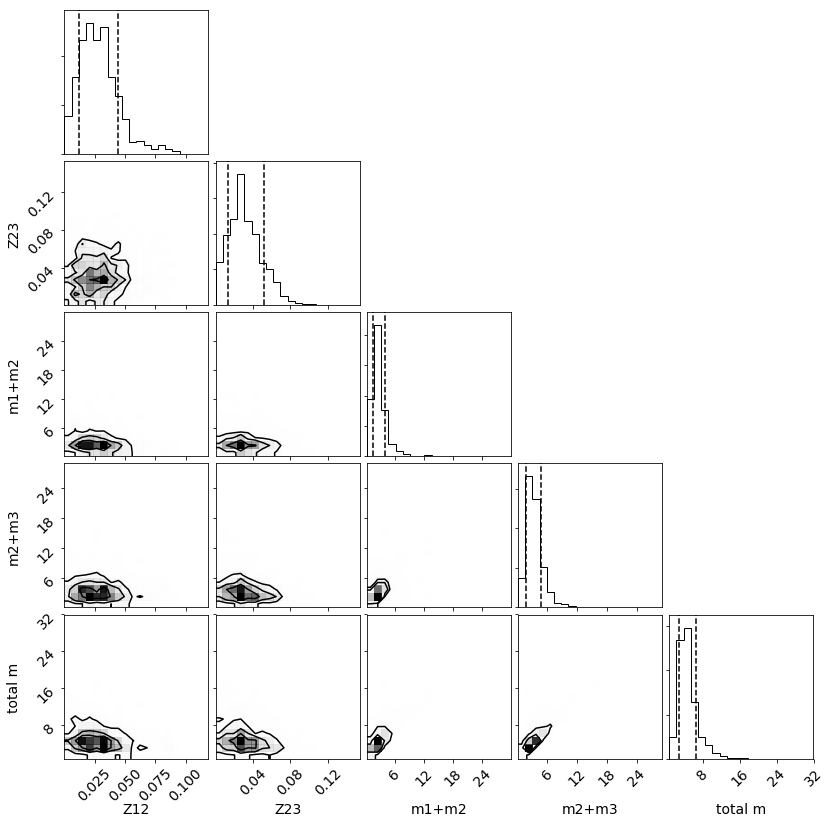

In [6]:
labels = ["Z12", "Z23", "m1+m2", "m2+m3", "total m"]
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False)
plt.show()
fig = corner.corner(df[labels], labels=labels, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.show()

"sigma" before: 0.921600
"sigma" after: 0.674592
factor of 1.366160 smaller
"sigma" before: 0.948657
"sigma" after: 0.812540
factor of 1.167519 smaller
"sigma" before: 1.398452
"sigma" after: 1.000518
factor of 1.397729 smaller


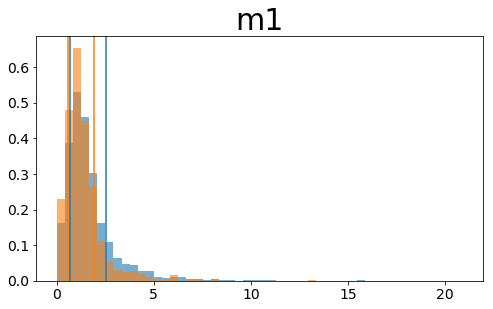

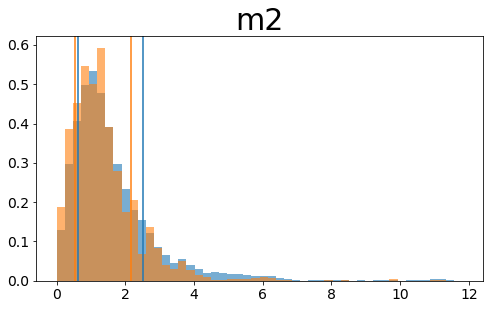

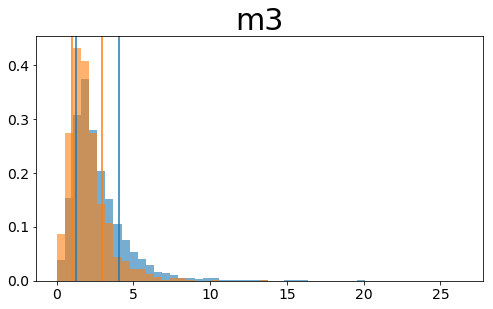

In [7]:
create_hist("m1")
create_hist("m2")
create_hist("m3")

"sigma" before: 1.524235
"sigma" after: 1.143709
factor of 1.332712 smaller
"sigma" before: 1.871056
"sigma" after: 1.396075
factor of 1.340226 smaller
"sigma" before: 2.293913
"sigma" after: 1.768158
factor of 1.297346 smaller


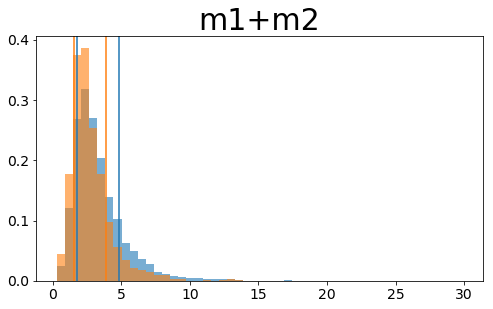

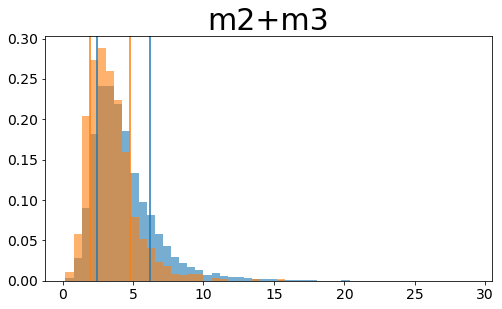

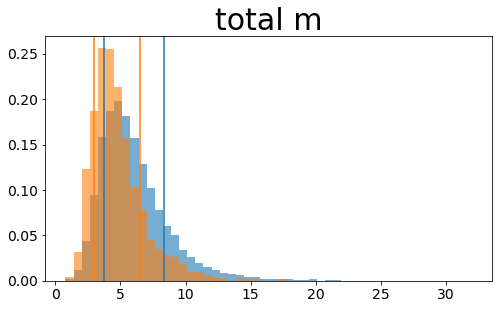

In [8]:
create_hist("m1+m2")
create_hist("m2+m3")
create_hist("total m")

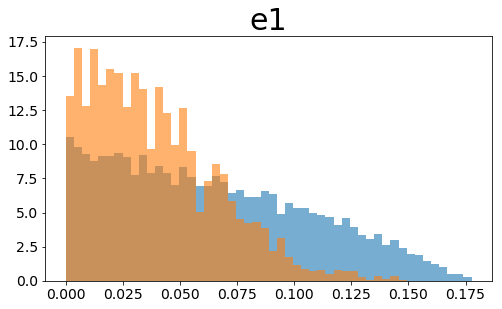

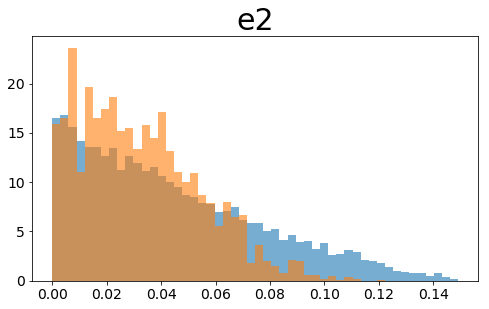

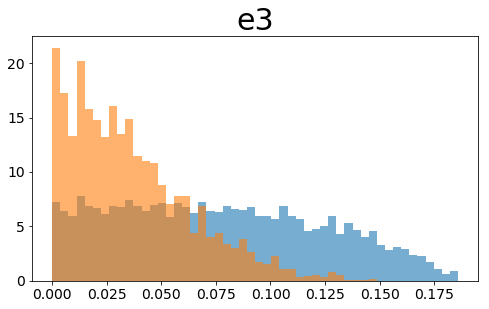

In [9]:
create_hist("e1", show_quantiles=False)
create_hist("e2", show_quantiles=False)
create_hist("e3", show_quantiles=False)

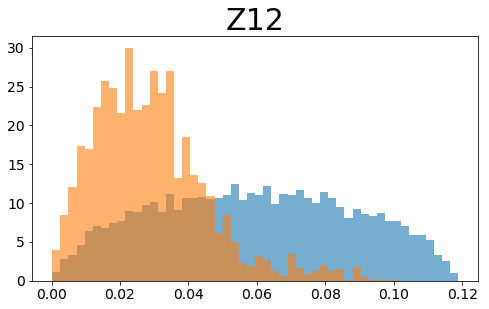

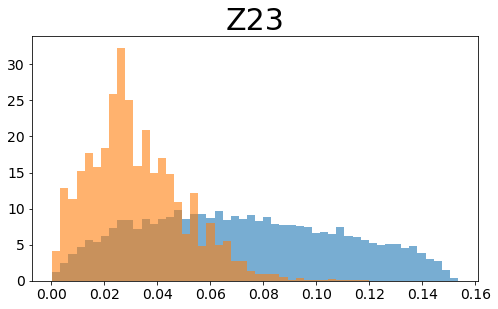

In [10]:
create_hist("Z12", show_quantiles=False)
create_hist("Z23", show_quantiles=False)

# Color plots

In [11]:
def create_color_plots(label):
    mass_data = df[label]
    transparency = 0.1
    s=200
    txtsize = 32
    low_thres=0.3
    hi_thres=0.7
    
    fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[24, 16])

    df_new = df[mass_data < np.quantile(mass_data, low_thres)]
    proba = df_new['probstability'].values
    axarr[0,0].scatter(df_new["k"], df_new["h"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[1,0].scatter(df_new["Z12"], df_new["Z23"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[0,0].text(-0.05, 0.12, 'low '+label, weight='bold', size=txtsize)

    df_new = df.iloc[[np.quantile(mass_data, hi_thres) > mass_data[i] > np.quantile(mass_data, low_thres) for i in range(len(mass_data))]]
    proba = df_new['probstability'].values
    axarr[0,1].scatter(df_new["k"], df_new["h"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[1,1].scatter(df_new["Z12"], df_new["Z23"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[0,1].text(-0.05, 0.12, 'mid '+label, weight='bold', size=txtsize)

    df_new = df[mass_data > np.quantile(mass_data, hi_thres)]
    proba = df_new['probstability'].values
    axarr[0,2].scatter(df_new["k"], df_new["h"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[1,2].scatter(df_new["Z12"], df_new["Z23"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[0,2].text(-0.05, 0.12, 'high '+label, weight='bold', size=txtsize)
    
    plt.subplots_adjust(wspace=0)
    axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
    axarr[0,1].set_yticklabels([])
#     axarr[0,2].tick_params(axis='y', which='both', left='off', right='off')
    axarr[0,0].text(-.3, .10, 'Physical Space', weight='bold', size=txtsize, rotation=90)


    axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
    axarr[0,0].set_ylabel(r'$e_{2y}$')
    axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
    axarr[0,2].set_xlabel(r'$e_{2x}$', labelpad=20)
    axarr[0,2].set_ylabel(r'$e_{2y}$')
    axarr[0,2].yaxis.set_label_position("right")
    axarr[0,0].xaxis.set_label_position("top")
    axarr[0,1].xaxis.set_label_position("top")
    axarr[0,2].xaxis.set_label_position("top")
    axarr[0,2].yaxis.tick_right()
    axarr[0,0].xaxis.tick_top()
    axarr[0,1].xaxis.tick_top()
    axarr[0,2].xaxis.tick_top()

#     axarr[1,2].tick_params(axis='y', which='both', left='off', right='off')
    axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
    axarr[1,1].set_yticklabels([])
    axarr[1,0].text(-0.09, 0.125, 'Feature Space', weight='bold', size=32, rotation=90)

    axarr[1,0].set_xlabel(r'$e_-^{12}$')
    axarr[1,0].set_ylabel(r'$e_-^{23}$')
    axarr[1,1].set_xlabel(r'$e_-^{12}$')
    axarr[1,2].set_xlabel(r'$e_-^{12}$')
    axarr[1,2].set_ylabel(r'$e_-^{23}$')
    axarr[1,2].yaxis.tick_right()
    axarr[1,2].yaxis.set_label_position("right")
    
    for ax in axarr.flatten():
        plt.setp(ax.xaxis.label, fontsize=30)
        plt.setp(ax.yaxis.label, fontsize=30)
        plt.setp(ax.get_xticklabels(), fontsize=24)
        plt.setp(ax.get_yticklabels(), fontsize=24)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


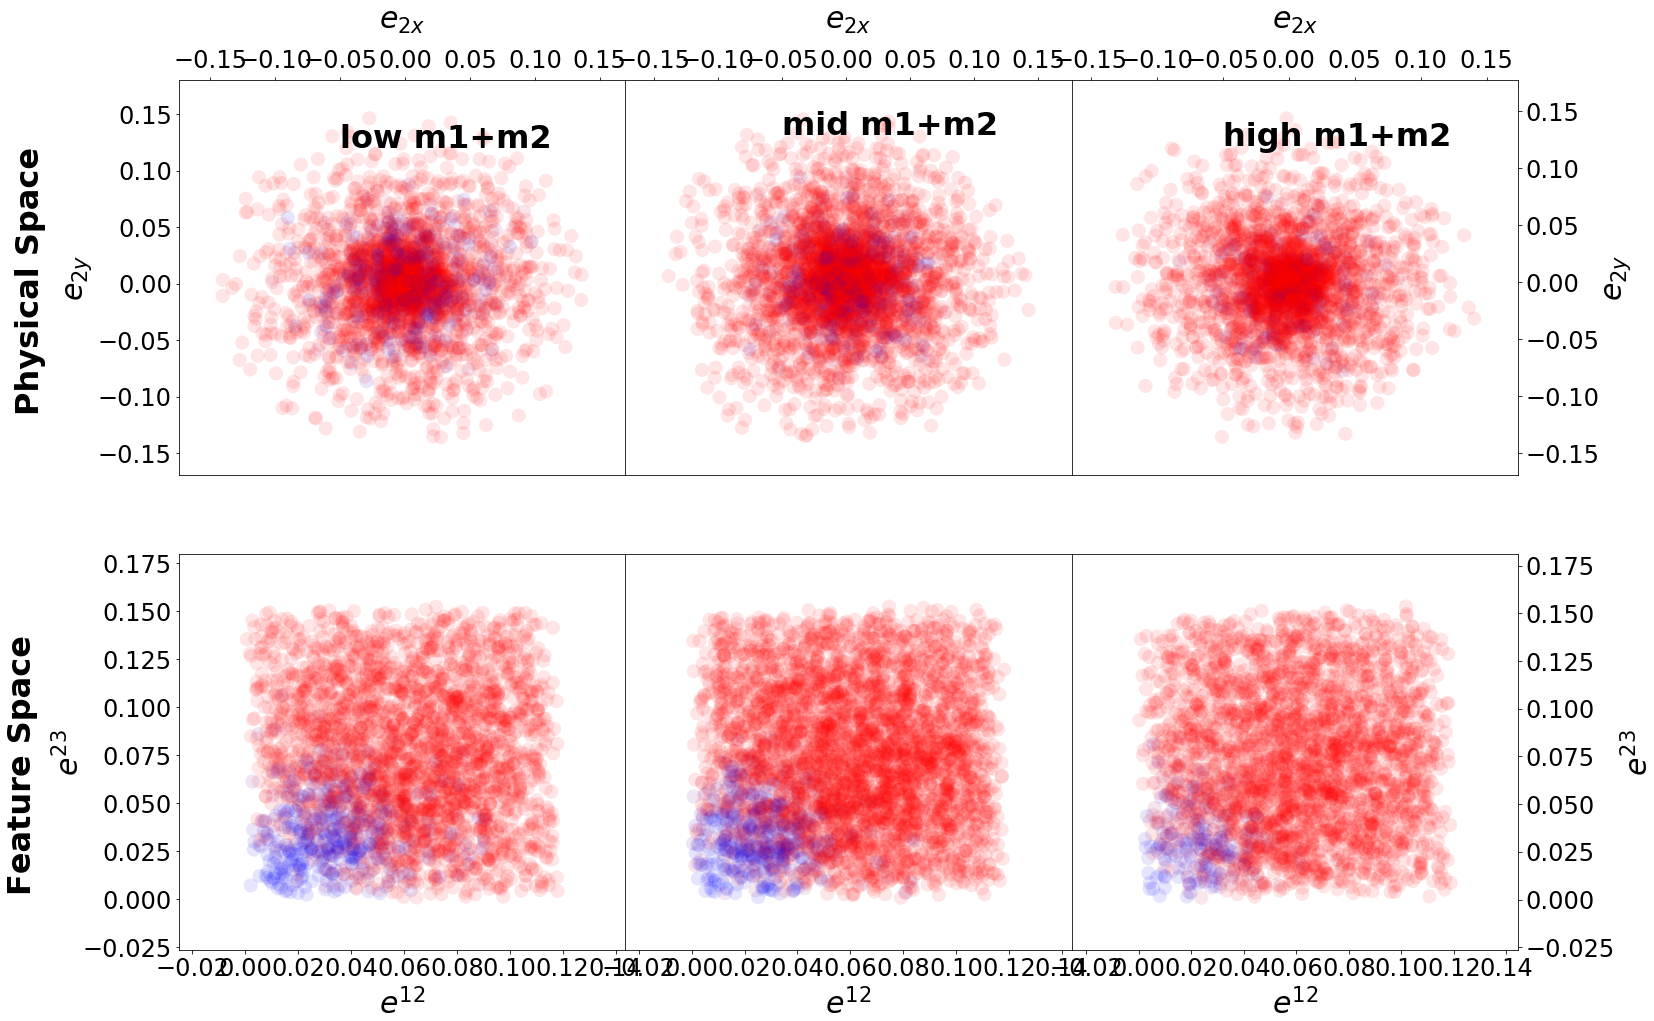

In [12]:
create_color_plots("m1+m2")

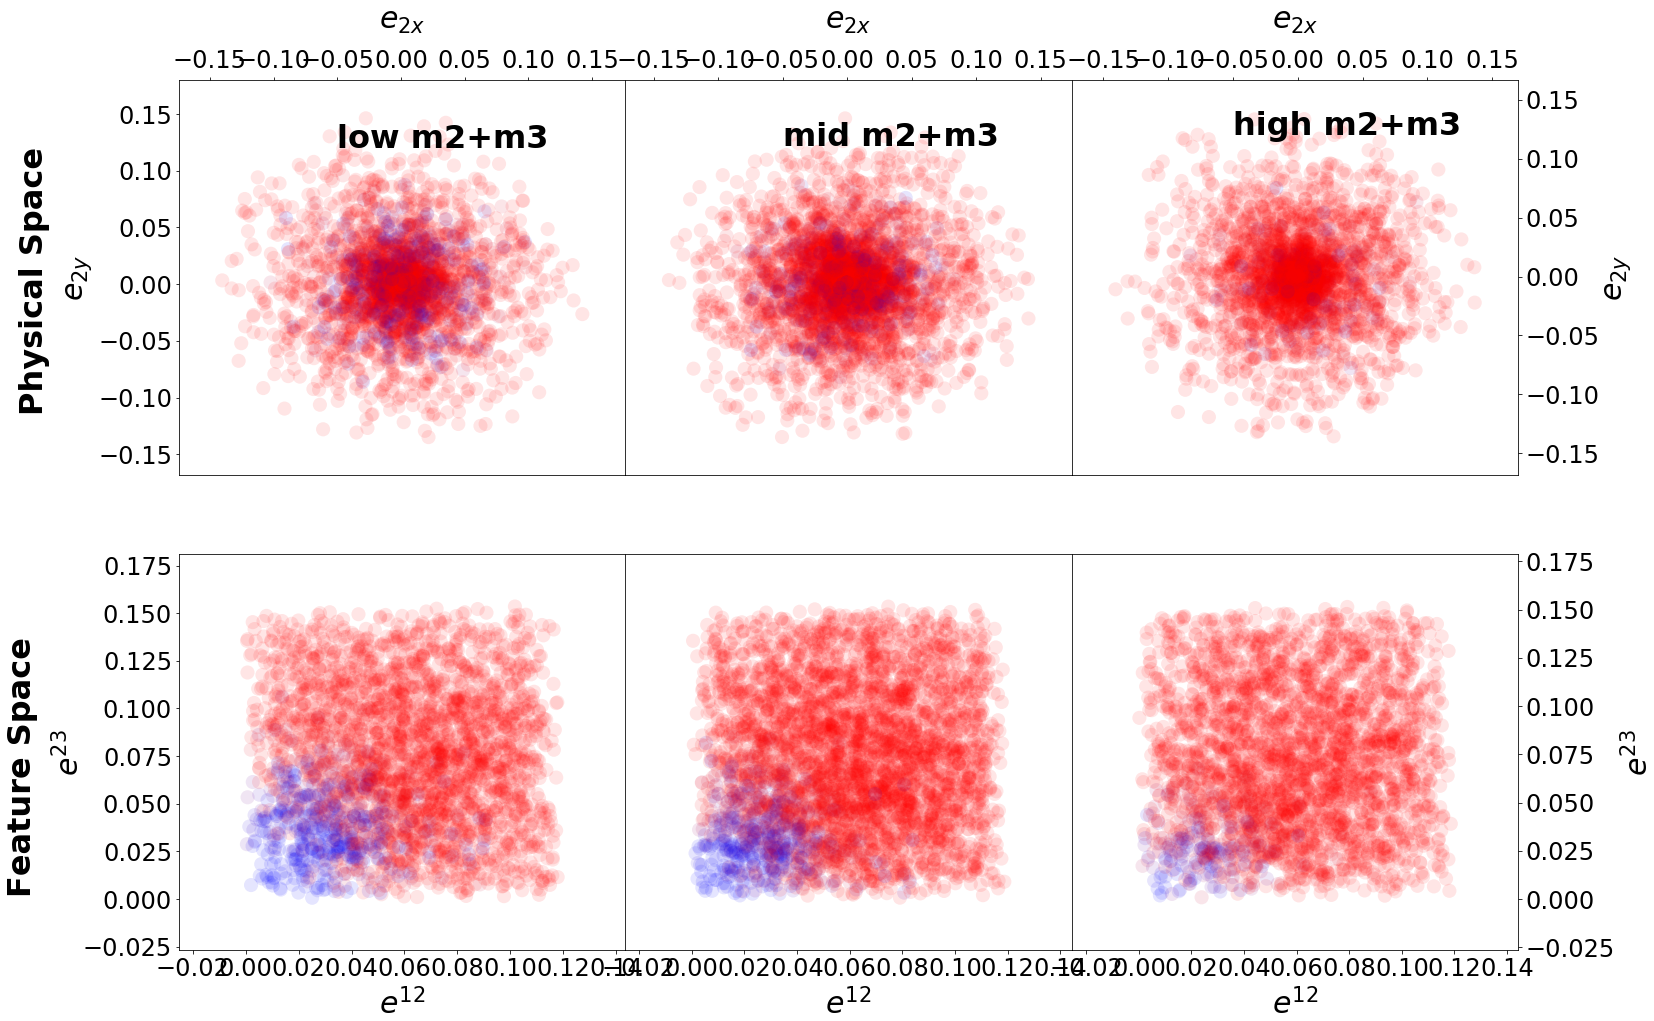

In [13]:
create_color_plots("m2+m3")

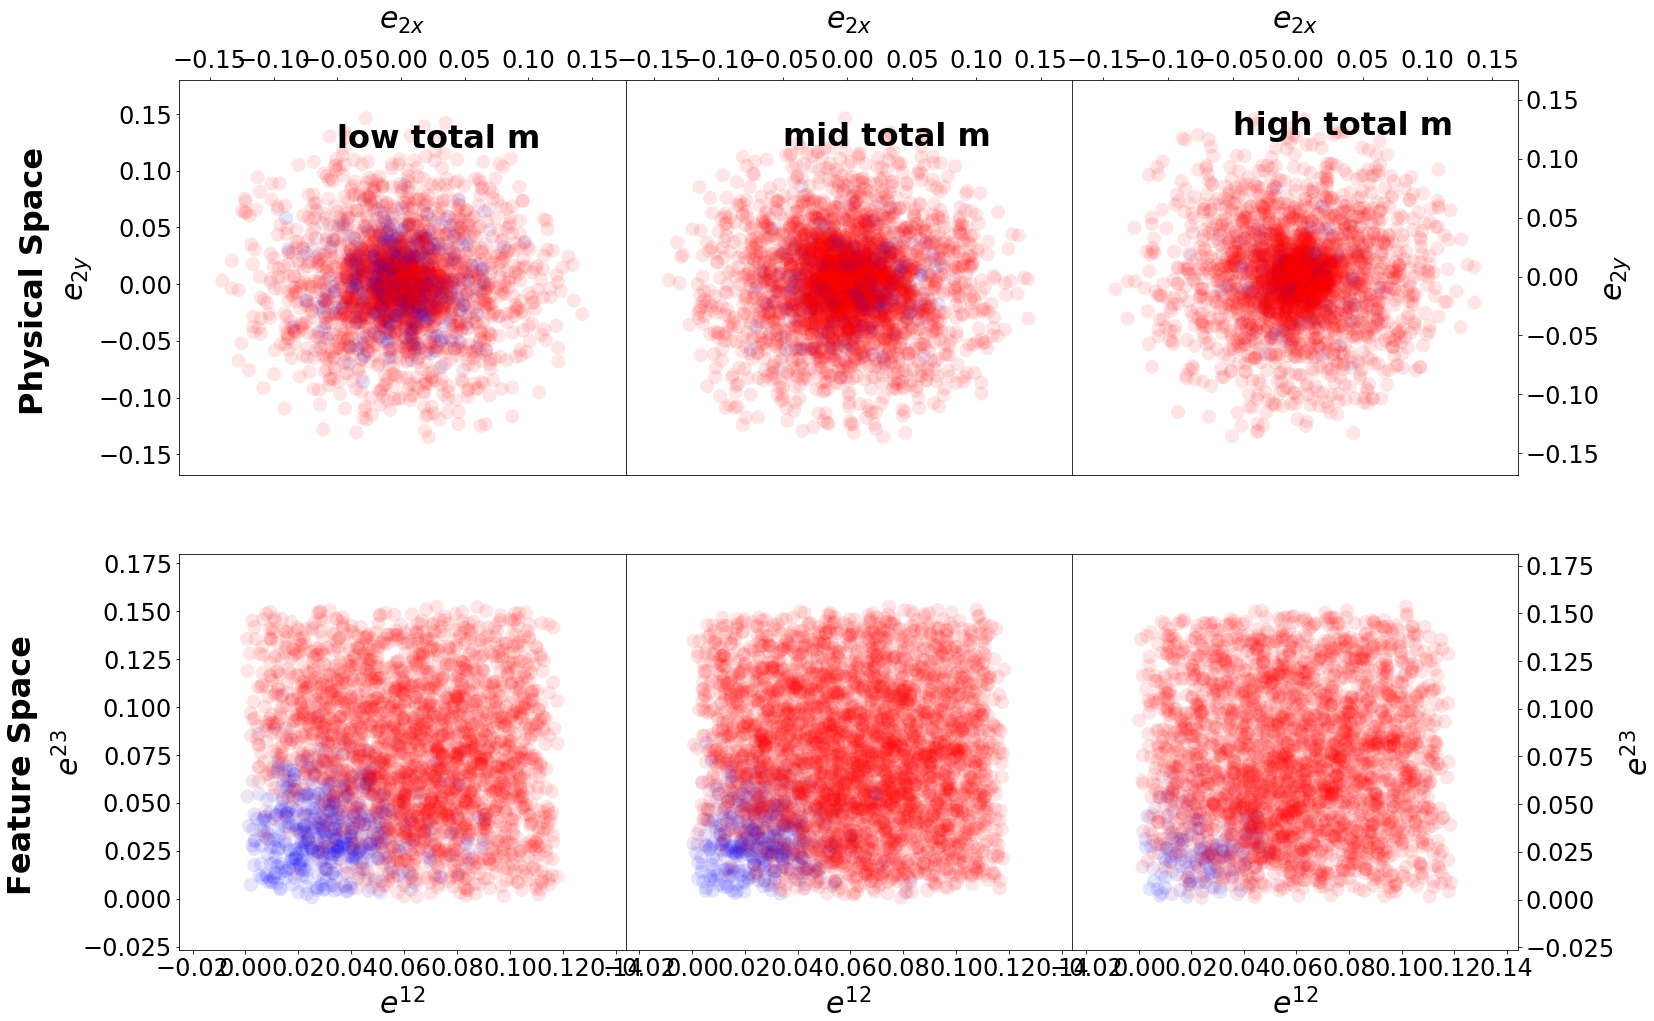

In [14]:
create_color_plots("total m")

In [15]:
def create_color_plots2(label):
    mass_data = df[label]
    transparency = 0.1
    s=200
    txtsize = 32
    low_thres=0.3
    hi_thres=0.7
    
    fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[24, 16])
    
    df_new = df[mass_data < np.quantile(mass_data, low_thres)]
    proba = df_new['probstability'].values
    axarr[0,0].scatter(df_new["e1"], df_new["e2"], c=proba, cmap=cmaprb, s=s*.75, lw=0, alpha=transparency)
    axarr[1,0].scatter(df_new["Z12"], df_new["Z23"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[0,0].text(0.05, 0.15, 'low '+label, weight='bold', size=txtsize)

    df_new = df.iloc[[np.quantile(mass_data, hi_thres) > mass_data[i] > np.quantile(mass_data, low_thres) for i in range(len(mass_data))]]
    proba = df_new['probstability'].values
    axarr[0,1].scatter(df_new["e1"], df_new["e2"], c=proba, cmap=cmaprb, s=s*.75, lw=0, alpha=transparency)
    axarr[1,1].scatter(df_new["Z12"], df_new["Z23"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[0,1].text(0.05, 0.15, 'mid '+label, weight='bold', size=txtsize)

    df_new = df[mass_data > np.quantile(mass_data, hi_thres)]
    proba = df_new['probstability'].values
    axarr[0,2].scatter(df_new["e1"], df_new["e2"], c=proba, cmap=cmaprb, s=s*.75, lw=0, alpha=transparency)
    axarr[1,2].scatter(df_new["Z12"], df_new["Z23"], c=proba, cmap=cmaprb, s=s, lw=0, alpha=transparency)
    axarr[0,2].text(0.05, 0.15, 'high '+label, weight='bold', size=txtsize)
    
    plt.subplots_adjust(wspace=0)
    axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
    axarr[0,1].set_yticklabels([])
#     axarr[0,2].tick_params(axis='y', which='both', left='off', right='off')
    axarr[0,0].text(-.11, .15, 'Physical Space', weight='bold', size=txtsize, rotation=90)


    axarr[0,0].set_xlabel(r'$e_{1}$', labelpad=20)
    axarr[0,0].set_ylabel(r'$e_{2}$')
    axarr[0,1].set_xlabel(r'$e_{1}$', labelpad=20)
    axarr[0,2].set_xlabel(r'$e_{1}$', labelpad=20)
    axarr[0,2].set_ylabel(r'$e_{2}$')
    axarr[0,2].yaxis.set_label_position("right")
    axarr[0,0].xaxis.set_label_position("top")
    axarr[0,1].xaxis.set_label_position("top")
    axarr[0,2].xaxis.set_label_position("top")
    axarr[0,2].yaxis.tick_right()
    axarr[0,0].xaxis.tick_top()
    axarr[0,1].xaxis.tick_top()
    axarr[0,2].xaxis.tick_top()

#     axarr[1,2].tick_params(axis='y', which='both', left='off', right='off')
    axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
    axarr[1,1].set_yticklabels([])
    axarr[1,0].text(-0.09, 0.15, 'Feature Space', weight='bold', size=32, rotation=90)

    axarr[1,0].set_xlabel(r'$e_-^{12}$')
    axarr[1,0].set_ylabel(r'$e_-^{23}$')
    axarr[1,1].set_xlabel(r'$e_-^{12}$')
    axarr[1,2].set_xlabel(r'$e_-^{12}$')
    axarr[1,2].set_ylabel(r'$e_-^{23}$')
    axarr[1,2].yaxis.tick_right()
    axarr[1,2].yaxis.set_label_position("right")
    
    for ax in axarr.flatten():
        plt.setp(ax.xaxis.label, fontsize=30)
        plt.setp(ax.yaxis.label, fontsize=30)
        plt.setp(ax.get_xticklabels(), fontsize=24)
        plt.setp(ax.get_yticklabels(), fontsize=24)

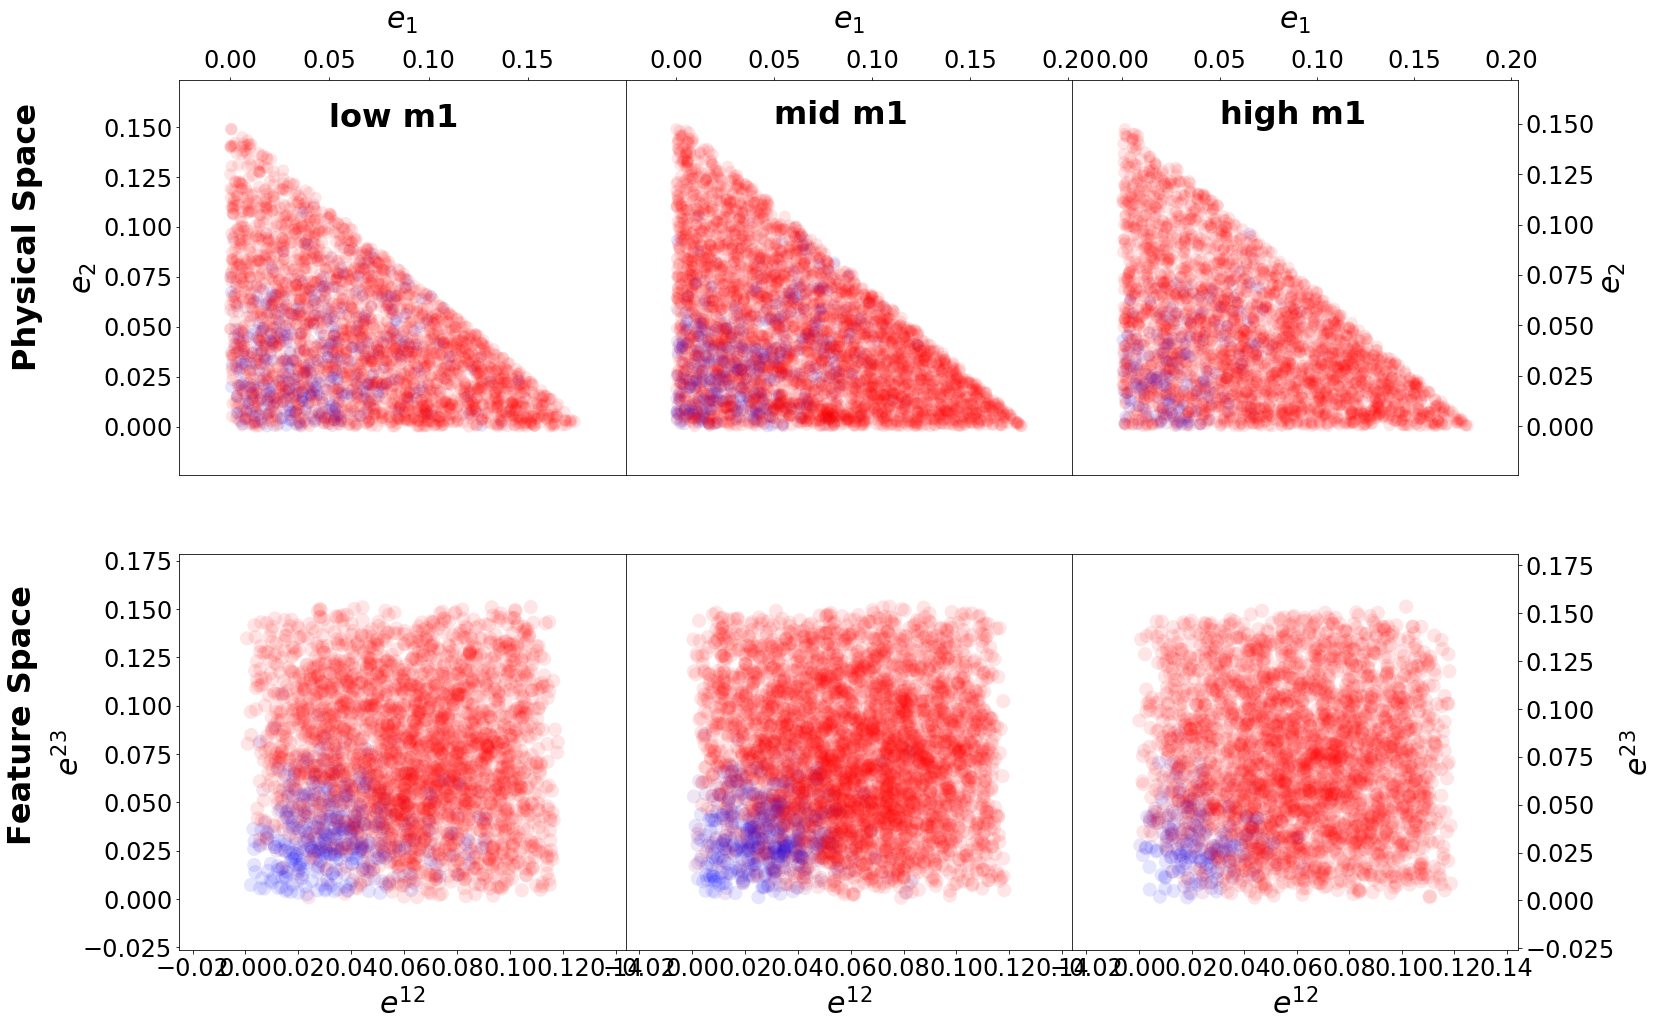

In [16]:
create_color_plots2("m1")

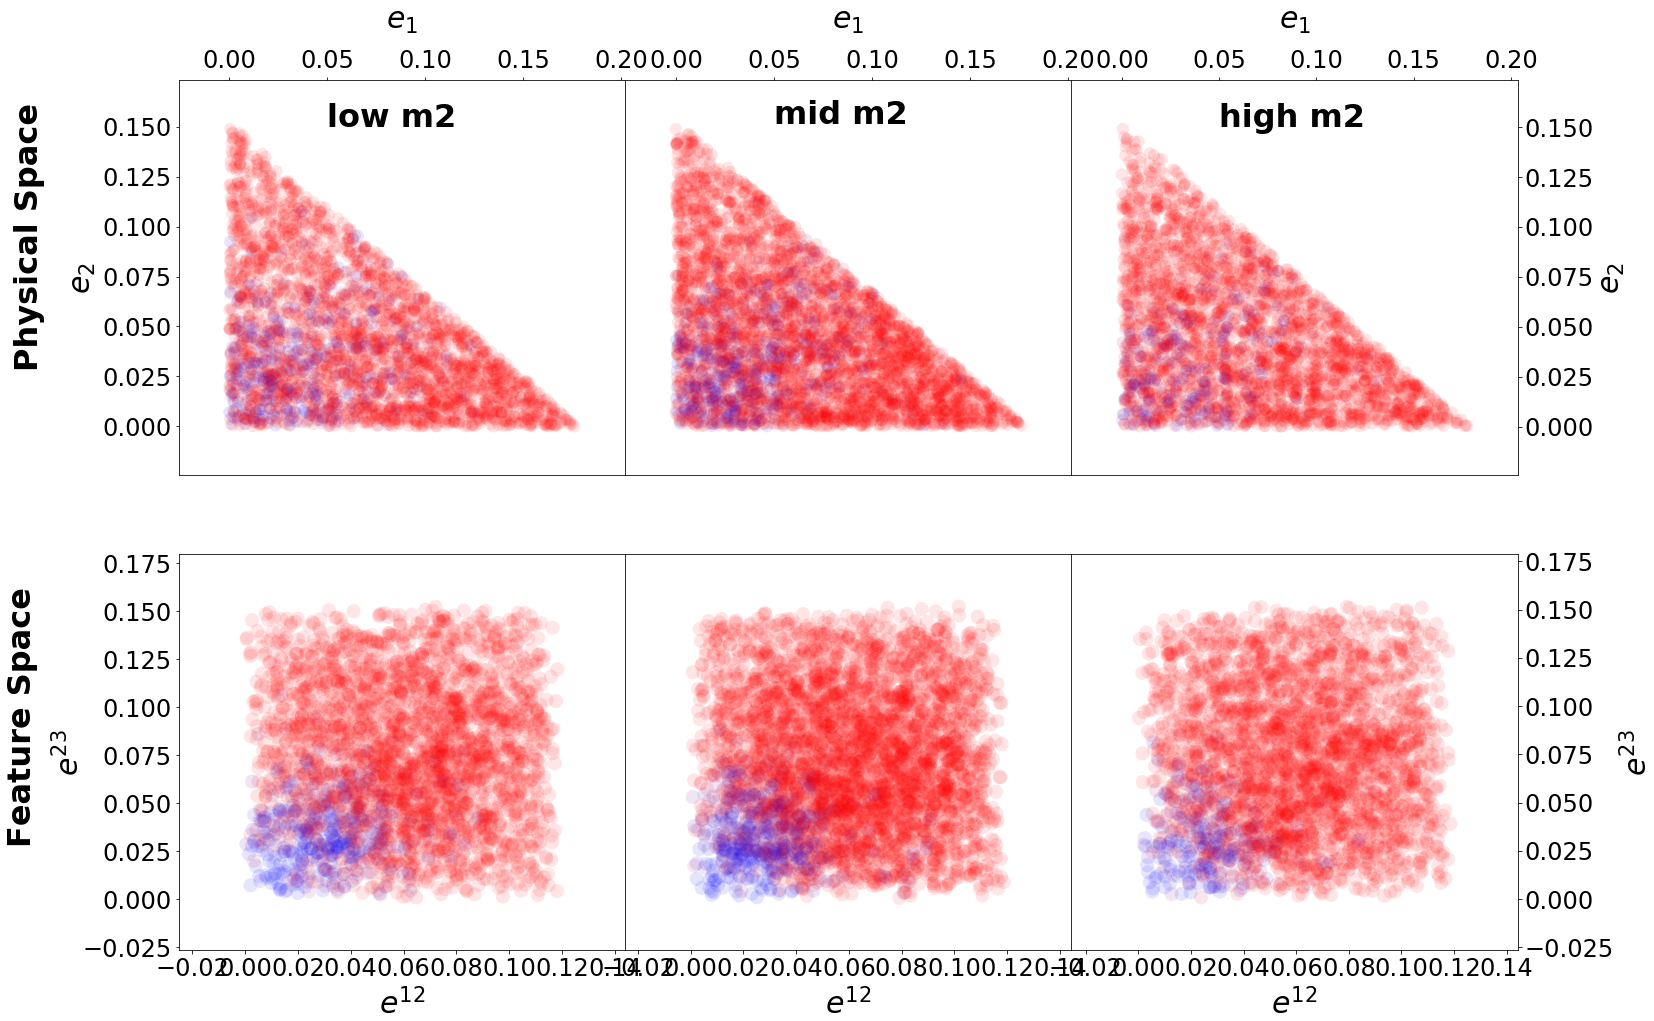

In [17]:
create_color_plots2("m2")

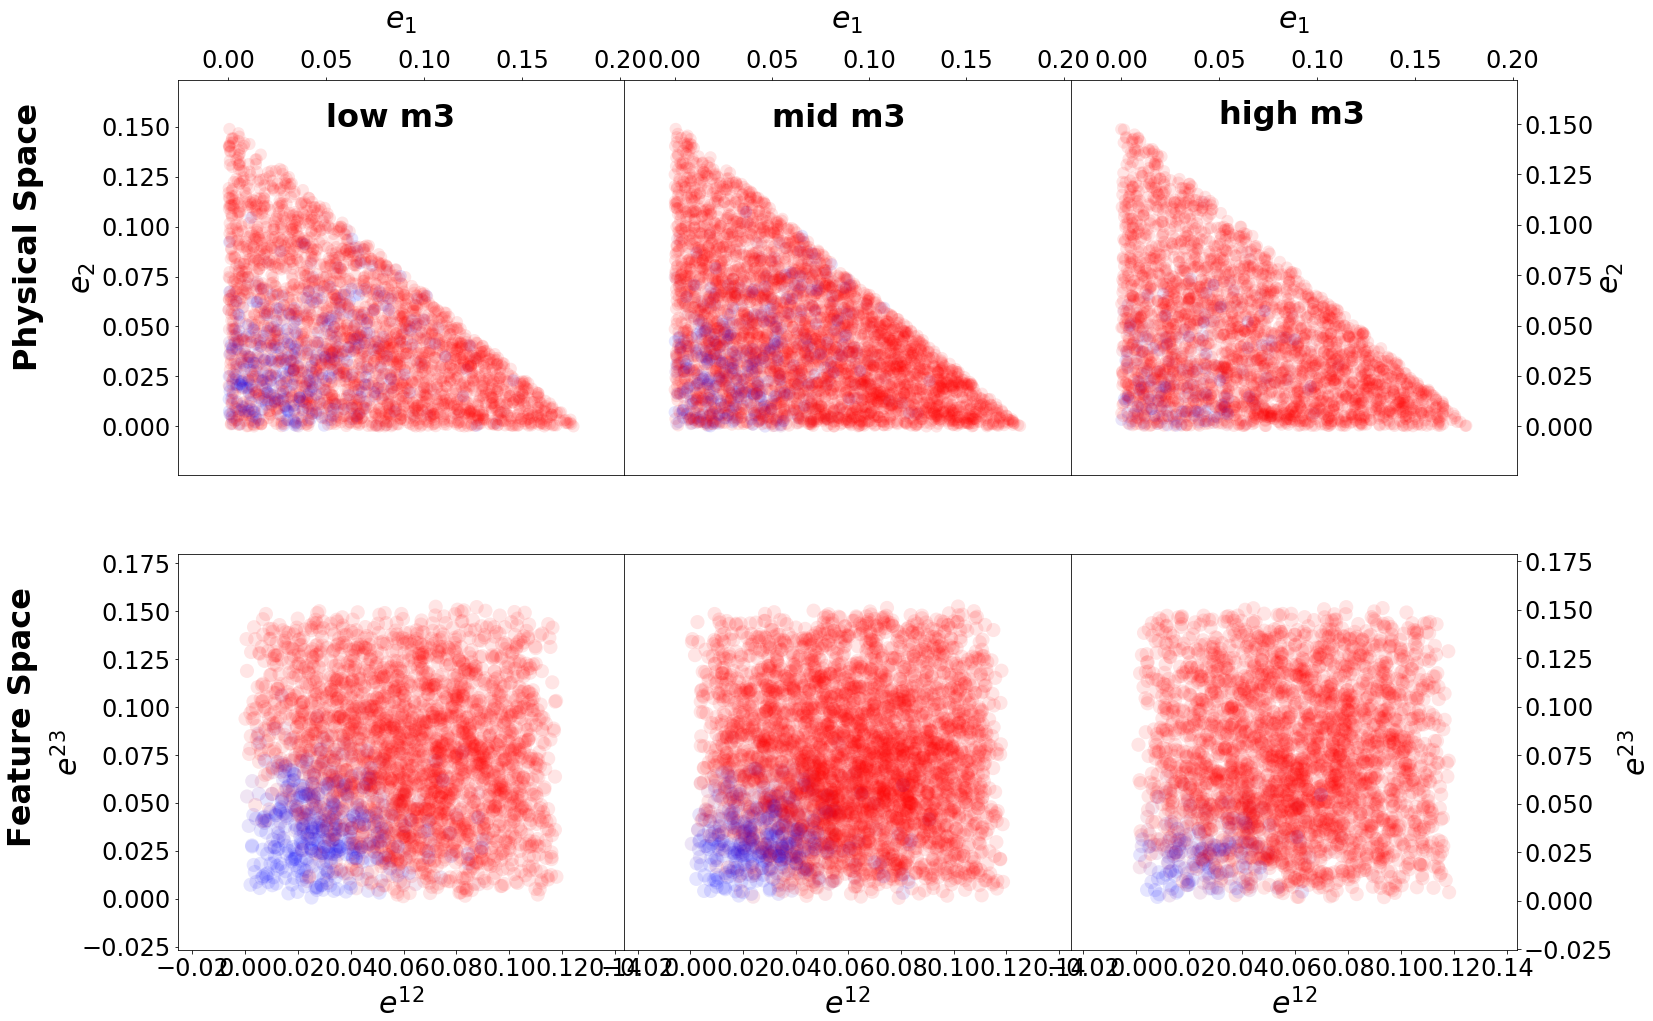

In [18]:
create_color_plots2("m3")